<a href="https://colab.research.google.com/github/ElPapi42/AgeClassifier/blob/master/AgeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
!pip install --upgrade tensorflow-gpu
!pip install --upgrade tqdm
!pip install --upgrade pillow
!pip install git+https://github.com/Jwink3101/parmapper
!pip install deepbay
clear_output()

In [0]:
#Imports
import os
import sys
import pathlib
import warnings

import PIL
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from parmapper import parmap
import deepbay

## Data Download

In [3]:
# Downloads and extract Dataset to local
# You can run this on google colab for get faster downloads speeds
import zipfile
import requests
from tqdm import tqdm

folder_path = "./Datasets"

appa_url = "http://158.109.8.102/AppaRealAge/appa-real-release.zip"
appa_path = folder_path + '/appa-real.zip'

# Create Dataset folder if not exists
if(not os.path.exists(folder_path)):
  os.mkdir(folder_path)

# download chalearn appa-real dataset
if(not(os.path.exists(appa_path) and os.path.isfile(appa_path))):
  resp = requests.get(appa_url, stream=True)

  total_size = int(resp.headers.get('content-length', 0))
  block_size = 16384
  t=tqdm(total=total_size, unit='iB', unit_scale=True)
  
  with open(appa_path, "wb") as f:
    for data in resp.iter_content(block_size):
      t.update(len(data))
      f.write(data)
    t.close()
    f.close()

    if total_size != 0 and t.n != total_size:
      print("Download Error")

  # Extract
  with zipfile.ZipFile(appa_path, 'r') as zip:
    zip.extractall(folder_path)
    zip.close()

100%|██████████| 885M/885M [03:12<00:00, 4.60MiB/s]


## Exploratory Data Analysis

In [0]:
# Load Datasets
df_train = pd.read_csv("/content/Datasets/appa-real-release/gt_avg_train.csv")
df_eval = pd.read_csv("/content/Datasets/appa-real-release/gt_avg_valid.csv")
df_test = pd.read_csv("/content/Datasets/appa-real-release/gt_avg_test.csv")
df_all = pd.concat([df_train, df_eval, df_test])

In [5]:
# Lets see some examples
df_all.head()

,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age
0,000000.jpg,36,5.000000,1.146423,4
1,000001.jpg,63,20.079365,4.096819,18
2,000002.jpg,38,76.815789,6.133009,80
3,000003.jpg,38,55.657895,7.864653,50
4,000004.jpg,15,17.666667,3.457222,17


In [6]:
# Check for nulls and other general info
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7591 entries, 0 to 1977
Data columns (total 5 columns):
file_name           7591 non-null object
num_ratings         7591 non-null int64
apparent_age_avg    7591 non-null float64
apparent_age_std    7591 non-null float64
real_age            7591 non-null int64
dtypes: float64(2), int64(2), object(1)
memory usage: 355.8+ KB


In [7]:
# Descriptive stats
df_all.describe()

,num_ratings,apparent_age_avg,apparent_age_std,real_age
count,7591.000000,7591.000000,7591.000000,7591.000000
mean,34.337505,30.965106,4.339865,31.201159
std,27.788812,15.627235,1.877274,17.145060
min,10.000000,0.923077,0.000000,1.000000
25%,14.000000,21.974679,3.149931,20.000000
50%,37.000000,28.727273,4.357660,29.000000
75%,39.000000,38.975973,5.509453,41.000000
max,609.000000,95.567568,14.510423,100.000000


In [8]:
# Dataset slices sizes
train_size = df_train.count()[0]
eval_size = df_eval.count()[0]
test_size = df_test.count()[0]

print("Train: " + str(train_size))
print("Evaluation: " + str(eval_size))
print("Test: " + str(test_size))

Train: 4113
Evaluation: 1500
Test: 1978


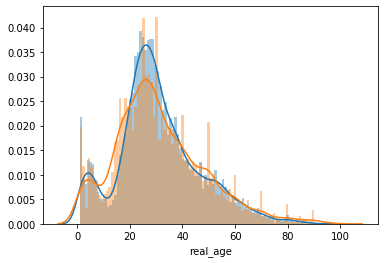

In [9]:
# Lets see the distribution of the apparent age and the real age
sns.distplot(df_all["apparent_age_avg"], bins=100)
sns.distplot(df_all["real_age"], bins=100)

The Distribution of age dont deviate too much between the real and the apparent, we can keep it

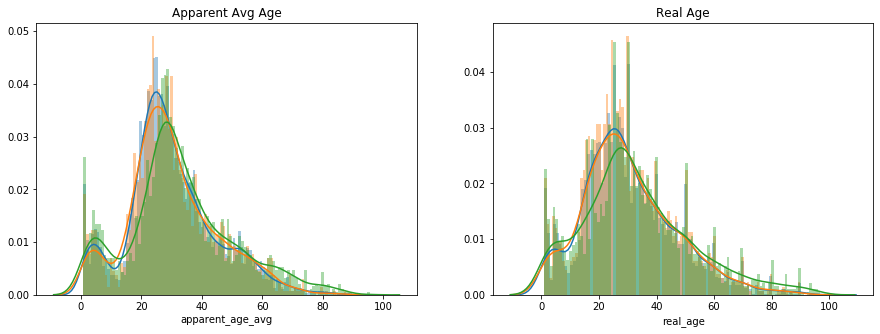

In [10]:
# Now we will check the dist between the train, eval and test datasets
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1, title="Apparent Avg Age")
sns.distplot(df_train["apparent_age_avg"], bins=100)
sns.distplot(df_eval["apparent_age_avg"], bins=100)
sns.distplot(df_test["apparent_age_avg"], bins=100)

plt.subplot(1, 2, 2, title="Real Age")
sns.distplot(df_train["real_age"], bins=100)
sns.distplot(df_eval["real_age"], bins=100)
sns.distplot(df_test["real_age"], bins=100)

plt.show()

This one can be better, dist of test set deviates a bit from train set, but we can keep with this for now. But this visualizations open some questions, how much the avg age deviates from the real age? putting a response here can lead us to detect some possible outliers, because the avg is based on manual reviews from real people that stimates the age of the person they see in the photo. Lets check that

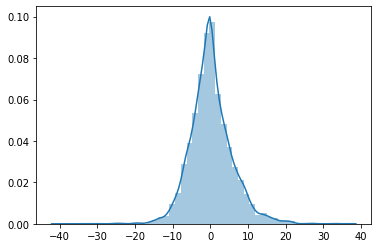

In [11]:
diference = df_all["real_age"] - df_all["apparent_age_avg"]
sns.distplot(diference, bins=50)

We will ignore this deviation for now, but we can keep in mind this for the future

## Preprocessing

In [12]:
# Find URLs
df_train["file_url"] = "./Datasets/appa-real-release/train/" + df_train["file_name"] + "_face.jpg"
df_eval["file_url"] = "./Datasets/appa-real-release/valid/" + df_eval["file_name"] + "_face.jpg"
df_test["file_url"] = "./Datasets/appa-real-release/test/" + df_test["file_name"] + "_face.jpg"
df_all = pd.concat([df_train, df_eval, df_test])
df_train.head()

,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age,file_url
0,000000.jpg,36,5.000000,1.146423,4,./Datasets/appa-real-release/train/000000.jpg_...
1,000001.jpg,63,20.079365,4.096819,18,./Datasets/appa-real-release/train/000001.jpg_...
2,000002.jpg,38,76.815789,6.133009,80,./Datasets/appa-real-release/train/000002.jpg_...
3,000003.jpg,38,55.657895,7.864653,50,./Datasets/appa-real-release/train/000003.jpg_...
4,000004.jpg,15,17.666667,3.457222,17,./Datasets/appa-real-release/train/000004.jpg_...


In [13]:
# Bucketize age into groups, ex: 0-2, 3-5

buckets = np.linspace(0, 99, 34)

df_train["bucketized_age"] = pd.cut(df_train["apparent_age_avg"], buckets).astype("str")
df_eval["bucketized_age"] = pd.cut(df_eval["apparent_age_avg"], buckets).astype("str")
df_test["bucketized_age"] = pd.cut(df_test["apparent_age_avg"], buckets).astype("str")

# Cats will contain the mapping between the Categorical Age Range and the index Representing it
cats = np.unique(np.concatenate([df_train["bucketized_age"].values, df_eval["bucketized_age"].values, df_test["bucketized_age"].values]))
cats_count = len(cats)

def encode_category(cat):
  return np.where(cats == cat)[0][0]

df_train["encoded_age"] = df_train["bucketized_age"].apply(encode_category)
df_eval["encoded_age"] = df_eval["bucketized_age"].apply(encode_category)
df_test["encoded_age"] = df_test["bucketized_age"].apply(encode_category)

print("Number of Age Ranges in the Dataset: {}".format(cats_count))

Number of Age Ranges in the Dataset: 31


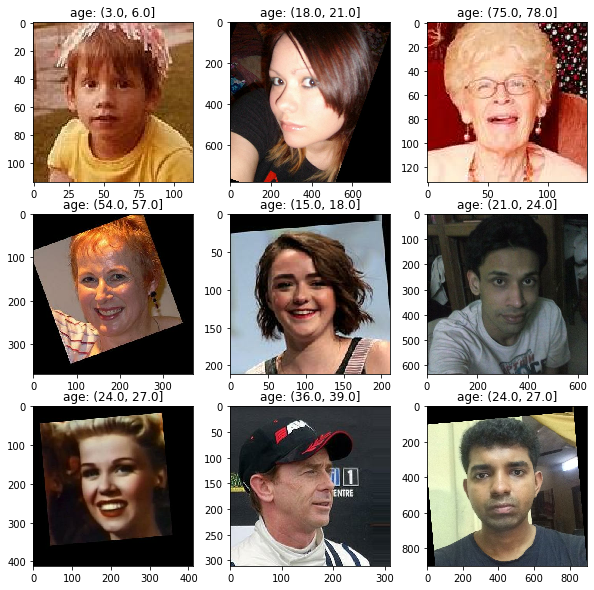

In [14]:
#Lets see some examples
plt.figure(figsize=(10,10))
for i, path in enumerate(df_train["file_url"].iloc[:9]):
  image = tf.io.read_file(path)
  image = tf.image.decode_image(image)

  datapoint = df_train[df_train["file_url"] == path]
  age = datapoint["bucketized_age"].values[0]

  plt.subplot(3,3,i+1, title="age: {age}".format(age=age))
  plt.imshow(image)
plt.show()

## Dataset Creation

In [0]:
# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_image(image)
  image = tf.image.resize_with_pad(image, 384, 384, antialias=True)
  return image, label

# Transform Image
def transform_image(image_batch, label_batch):
  image_batch = image_batch / 255.0
  image_batch = tf.image.random_crop(image_batch, [tf.shape(image_batch)[0], 256, 256, 3])
  image_batch = tf.image.random_flip_left_right(image_batch)
  image_batch = tf.image.random_brightness(image_batch, 0.5)
  return image_batch, label_batch

In [0]:
# Create Datasets for train, evaluation and testing
def generate_datasets(train_batch_size):
  # Train
  train_ds = tf.data.Dataset.from_tensor_slices((df_train["file_url"], df_train["encoded_age"]))
  train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  train_ds = train_ds.batch(train_batch_size)
  train_ds = train_ds.map(transform_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  train_df = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  # Evaluation
  eval_ds = tf.data.Dataset.from_tensor_slices((df_eval["file_url"], df_eval["encoded_age"]))
  eval_ds = eval_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  eval_ds = eval_ds.batch(128)
  eval_ds = eval_ds.map(transform_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  eval_ds = eval_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  # Testing
  test_ds = tf.data.Dataset.from_tensor_slices((df_test["file_url"], df_test["encoded_age"]))
  test_ds = test_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  test_ds = test_ds.batch(128)
  test_ds = test_ds.map(transform_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return train_ds, eval_ds, test_ds

We can still implement interleave to the input pipeline of the datasets, lets keep that in mind for later

## Model Definition
We will use ResNet50 pretrained on ImageNet as model base

In [0]:
class Conv2DBlock(tf.keras.Model):
  """
  Packages BatchNorm, Dropout, Convolution and Pooling in a single layer/model

  args:
    filters, 
    kernel_size, 
    strides=1, 
    padding="same", 
    activation="linear", 
    pool_size=2,
    dropout=0.0, 
    use_batch_norm=True,
    **kwargs


  """

  def __init__(self, 
               filters, 
               kernel_size, 
               strides=1, 
               padding="same", 
               activation="linear", 
               pool_size=2, 
               use_batch_norm=False,
               **kwargs):
    super(Conv2DBlock, self).__init__()

    self.use_batch_norm = use_batch_norm
    if(self.use_batch_norm):
        self.bn = tf.keras.layers.BatchNormalization()

    self.conv = tf.keras.layers.Conv2D(filters=filters, 
                                       kernel_size=kernel_size, 
                                       strides=strides, 
                                       padding=padding, 
                                       activation=activation, 
                                       **kwargs)
    self.pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)
    
  def call(self, inputs):
    X = inputs

    if(self.use_batch_norm):
      X = self.bn(X)

    X = self.conv(X)
    X = self.pool(X)
    return X

In [0]:
class AgeClassifier(tf.keras.Model):
  """
  Age Classifier

  args:
    output_network (list): Array of ints where every position represents the number of unit in that layer
  
  """

  def __init__(self, output_network):
    super(AgeClassifier, self).__init__()

    self.resnet = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False)
    self.resnet.trainable = False

    self.conv_block_01 = Conv2DBlock(2048, 2)
    self.conv_block_02 = Conv2DBlock(2048, 2)

    self.gap = tf.keras.layers.GlobalAveragePooling2D()
    self.flat = tf.keras.layers.Flatten()
    
    self.output_network = deepbay.DeepFeedForward(output_network, dropout=0.0, l2=0.00001)
    self.softmax = tf.keras.layers.Softmax()

  def set_trainable_layers(self, trainable_layers):
    """
    Update the layers that can be trained on the resnet50v2 architecture

    args:
      trainable_layers (int): number of layers that can be trained. By default all the layers are not trainable
      example: trainable_layers=5 means only the last 5 layers of ResNet50V2 are trainable, the remaining have freezed weights.
        ResNet50V2 have 190 layers, be careful for not exceed this number

    """

    if(trainable_layers != 0):
      # Set all the resnet architecture to be trainable
      self.resnet.trainable = True

      # Get total number of layers in Resnet50V2
      resnet_len = len(self.resnet.layers)

      # Disable the unnecesary layers for the trainable request
      for layer in self.resnet.layers[:resnet_len - trainable_layers]:
        layer.trainable = False
        
    else:
      self.resnet.trainable = False

  def call(self, inputs):
    X = self.resnet(inputs)
    X = self.conv_block_01(X)
    X = self.conv_block_02(X)
    print(tf.shape(X))
    X = self.gap(X)
    X = self.flat(X)
    X = self.output_network(X)
    X = self.softmax(X)
    return X

## Training

In [0]:
# Hyper Parameters
hparams = {
    "batch_size": 8,
    "lr": 0.0001,
    "output_network": [256, 64, cats_count]
}

In [0]:
# Instantiate Datasets
train_ds, eval_ds, test_ds = generate_datasets(hparams["batch_size"])

In [47]:
# Init Classifier
age_classifier = AgeClassifier(hparams["output_network"])
age_classifier.compile(
    tf.keras.optimizers.Adam(hparams["lr"]),
    tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)
age_classifier.train_on_batch(train_ds.take(1))
age_classifier.summary()

Tensor("age_classifier_7/Shape:0", shape=(4,), dtype=int32)
tf.Tensor([   8    2    2 2048], shape=(4,), dtype=int32)
Model: "age_classifier_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, None, None, 2048)  23564800  
_________________________________________________________________
conv2d_block_10 (Conv2DBlock multiple                  16779264  
_________________________________________________________________
conv2d_block_11 (Conv2DBlock multiple                  16779264  
_________________________________________________________________
global_average_pooling2d_6 ( multiple                  0         
_________________________________________________________________
flatten_6 (Flatten)          multiple                  0         
_________________________________________________________________
deep_feed_forward_7 (DeepFee multiple                  552479   

In [48]:
# Pre-Training
train_epochs = 10
age_classifier.fit(train_ds, epochs=train_epochs, validation_data=eval_ds)

Epoch 1/10
Tensor("age_classifier_7/Shape:0", shape=(4,), dtype=int32)
    515/Unknown - 95s 184ms/step - loss: 3.0576 - sparse_categorical_accuracy: 0.1097Tensor("age_classifier_7/Shape:0", shape=(4,), dtype=int32)
515/515 [==============================] - 117s 227ms/step - loss: 3.0576 - sparse_categorical_accuracy: 0.1097 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/10
515/515 [==============================] - 112s 218ms/step - loss: 2.8286 - sparse_categorical_accuracy: 0.1605 - val_loss: 3.1688 - val_sparse_categorical_accuracy: 0.1047
Epoch 3/10
515/515 [==============================] - 112s 217ms/step - loss: 2.7561 - sparse_categorical_accuracy: 0.1731 - val_loss: 3.1645 - val_sparse_categorical_accuracy: 0.1333
Epoch 4/10
515/515 [==============================] - 113s 219ms/step - loss: 2.7047 - sparse_categorical_accuracy: 0.1913 - val_loss: 3.0731 - val_sparse_categorical_accuracy: 0.1347
Epoch 5/10
515/515 [==============================]

In [0]:
# Unfreeze resnet layers
age_classifier.set_trainable_layers(20)
age_classifier.compile(
    tf.keras.optimizers.Adam(hparams["lr"] / 10.0),
    tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)
age_classifier.summary()

In [0]:
# Fine-tune
fine_epochs = 5
age_classifier.fit(train_ds, epochs=train_epochs + fine_epochs, initial_epoch=train_epochs, validation_data=eval_ds)

In [0]:
# Evaluate Performance
age_classifier.evaluate(test_ds)

In [0]:
for img, label in train_ds.take(1):
  print(img.shape)

In [0]:
age_classifier.resnet.trainable = True
age_classifier.resnet.layers[-1].trainable = False
age_classifier.resnet.trainable = True
age_classifier.resnet.layers[-2].trainable

In [0]:
# Vizualize Results
for img, label in test_ds.take(1):#.unbatch().take(1).batch(1):
  r = age_classifier(img)
  max = np.reshape(np.amax(r, axis=1), [-1, 1])

  index = np.where(r == max)[1]
  index = [cats[i] for i in index]
  index = np.reshape(index, [-1, 1])

  label = [cats[i] for i in label]
  label = np.reshape(label, [-1, 1])

  pred = np.concatenate([index, label], axis=1)
  print(pred)

In [0]:
import time
start_time = time.time()

for img, label in train_ds.take(1):
  pass

print("--- %s seconds ---" % (time.time() - start_time))